In [64]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt


In [48]:
local='D://a_trash//MSFT.csv'
df_raw=pd.read_csv(local)
df_raw.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,222.529999,223.000000,214.809998,217.690002,211.605301,37130100
1,2021-01-05,217.259995,218.520004,215.699997,217.899994,211.809433,23823000
2,2021-01-06,212.169998,216.490005,211.940002,212.250000,206.317352,35930700
3,2021-01-07,214.039993,219.339996,213.710007,218.289993,212.188538,27694500
4,2021-01-08,218.679993,220.580002,217.029999,219.619995,213.481339,22956200


In [32]:
# path = Path(local)
# file_name = path.stem

# figure = go.Figure(data=[go.Candlestick(x=df_raw["Date"],
#                                         open=df_raw["Open"], high=df_raw["High"],
#                                         low=df_raw["Low"], close=df_raw["Close"])])
# figure.update_layout(title = file_name+" Stock Price Analysis", xaxis_rangeslider_visible=False)
# figure.show()

In [49]:
#Chuyển đổi cột 'date' thành datetime
df_raw['Date'] = pd.to_datetime(df_raw['Date'])

# Tạo cột 'month_day' chỉ chứa tháng và ngày
df_raw['year-month-day'] = df_raw['Date'].dt.strftime('%Y-%m-%d')

In [50]:
average_values = df_raw.groupby('year-month-day')[['Open', 'High', 'Low','Close']].mean().reset_index()


In [51]:
df_raw.head(8)

,Date,Open,High,Low,Close,Adj Close,Volume,year-month-day
0,2021-01-04,222.529999,223.000000,214.809998,217.690002,211.605301,37130100,2021-01-04
1,2021-01-05,217.259995,218.520004,215.699997,217.899994,211.809433,23823000,2021-01-05
2,2021-01-06,212.169998,216.490005,211.940002,212.250000,206.317352,35930700,2021-01-06
3,2021-01-07,214.039993,219.339996,213.710007,218.289993,212.188538,27694500,2021-01-07
4,2021-01-08,218.679993,220.580002,217.029999,219.619995,213.481339,22956200,2021-01-08
5,2021-01-11,218.470001,218.910004,216.729996,217.490005,211.410889,23031300,2021-01-11
6,2021-01-12,216.500000,217.100006,213.320007,214.929993,208.922440,23249300,2021-01-12
7,2021-01-13,214.020004,216.759995,213.929993,216.339996,210.293045,20087100,2021-01-13


In [52]:
average_values.head()

,year-month-day,Open,High,Low,Close
0,2021-01-04,222.529999,223.000000,214.809998,217.690002
1,2021-01-05,217.259995,218.520004,215.699997,217.899994
2,2021-01-06,212.169998,216.490005,211.940002,212.250000
3,2021-01-07,214.039993,219.339996,213.710007,218.289993
4,2021-01-08,218.679993,220.580002,217.029999,219.619995


In [53]:

dataset = average_values.drop(columns=['year-month-day']).to_numpy()
print(dataset.shape)

(753, 4)


           Open      High       Low     Close
Open   1.000000  0.998023  0.997853  0.994981
High   0.998023  1.000000  0.997551  0.997754
Low    0.997853  0.997551  1.000000  0.997872
Close  0.994981  0.997754  0.997872  1.000000


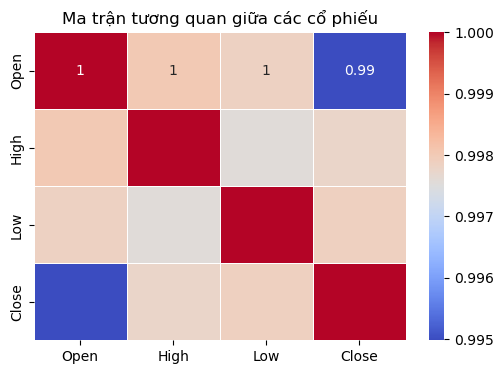

In [54]:
# Tính toán ma trận tương quan
correlation_matrix = average_values.drop(columns=['year-month-day']).corr()

# In ma trận tương quan
print(correlation_matrix)

# Vẽ ma trận tương quan
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Ma trận tương quan giữa các cổ phiếu')
plt.show()


In [56]:
#chia tập dữ liệu 1 bộ train và test
dt_Train,dt_Test = train_test_split(dataset,test_size=0.2,shuffle=False)

In [57]:
print('số lượng mẫu cho tập train: {}'.format(dt_Train.size))
print('số lượng mẫu cho tập train: {}'.format(dt_Test.size))

số lượng mẫu cho tập train: 2408
số lượng mẫu cho tập train: 604


In [59]:
### multivariate lstm model


In [60]:
# hàm chia timestep
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [61]:
n_steps = 3
X, y = split_sequences(dt_Train, n_steps)
print('chọn timesteps là 3 nên số mẫu dữ liệu train được đưa vào mô hình có dạng:')
print('mẫu                  : {} lần lượt là (số lượng mẫu, n_steps, 3 features open, high, low)'.format(X.shape))
print('giá cổ phếu cuối cùng: {}'.format(y.shape))

chọn timesteps là 3 nên số mẫu dữ liệu train được đưa vào mô hình có dạng:
mẫu                  : (600, 3, 3) lần lượt là (số lượng mẫu, n_steps, 3 features open, high, low)
giá cổ phếu cuối cùng: (600,)


In [62]:
# thiết kế mô hình
n_features=X.shape[1]
import time
start_time = time.time()

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=2500, verbose=0)
end_time = time.time()
execution_time = end_time - start_time
print("Thời gian chạy mô hình:", execution_time, "giây")

D:\code\anaconda4-22-2024\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Thời gian chạy mô hình: 221.03835010528564 giây


In [63]:
y_predict=[]
X_val, y_target = split_sequences(dt_Test, n_steps)

for step in X_val:
    x_input = step.reshape((1, n_steps, n_features))
    y_hat = model.predict(x_input, verbose=0)
    y_predict.append(y_hat.flatten()[0])
print("giá trị dự đoán: ")
print(y_predict)

giá trị dự đoán: 
[331.1513, 330.1961, 329.31323, 334.6493, 336.30197, 332.57498, 325.30045, 324.91614, 327.72513, 327.8681, 332.49496, 335.9138, 347.7874, 343.6704, 336.95886, 333.61072, 337.3741, 335.5367, 330.3484, 332.43414, 335.80637, 333.55432, 340.2998, 337.76157, 338.63876, 339.3336, 338.7256, 328.5249, 329.0134, 338.8461, 341.23633, 346.96698, 343.19754, 363.40555, 354.40744, 348.3485, 342.10947, 344.0918, 348.564, 335.4056, 331.90915, 337.59473, 334.52048, 335.90448, 327.23434, 328.11276, 330.3699, 328.9732, 324.44342, 322.5127, 323.65515, 320.33606, 321.99963, 322.4043, 321.93408, 317.51547, 313.85046, 320.3627, 322.06186, 326.83118, 322.7199, 321.20883, 323.18134, 326.59274, 327.30722, 328.00204, 328.1296, 332.4887, 331.33432, 330.3234, 333.46594, 335.9977, 332.50604, 334.5262, 337.83527, 330.64792, 327.71176, 326.67444, 322.27954, 318.78677, 317.56293, 315.80103, 311.2876, 311.41583, 312.5222, 316.2624, 318.90247, 313.24103, 317.88052, 316.2934, 326.90887, 326.95172, 327.8

In [72]:
print("----đánh giá độ đo----")
print("MAE: %.5f" %mae(y_predict,y_target))
print("MSE: %.5f" %mse(y_predict,y_target))
print("NSE: %.5f" %(1-(np.sum((y_target-y_predict)**2)/np.sum((y_target-np.mean(y_target))**2))))
print("R2: %.5f " %r2_score(y_target,y_predict))
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_target,np.array(y_predict).reshape(-1, 1))
print("mape:",mape)

----đánh giá độ đo----
MAE: 1.40991
MSE: 2.88794
NSE: 0.99253
R2: 0.99253 
mape: 0.004119708774483285


In [73]:
time=average_values['year-month-day'].iloc[-len(y_val):]


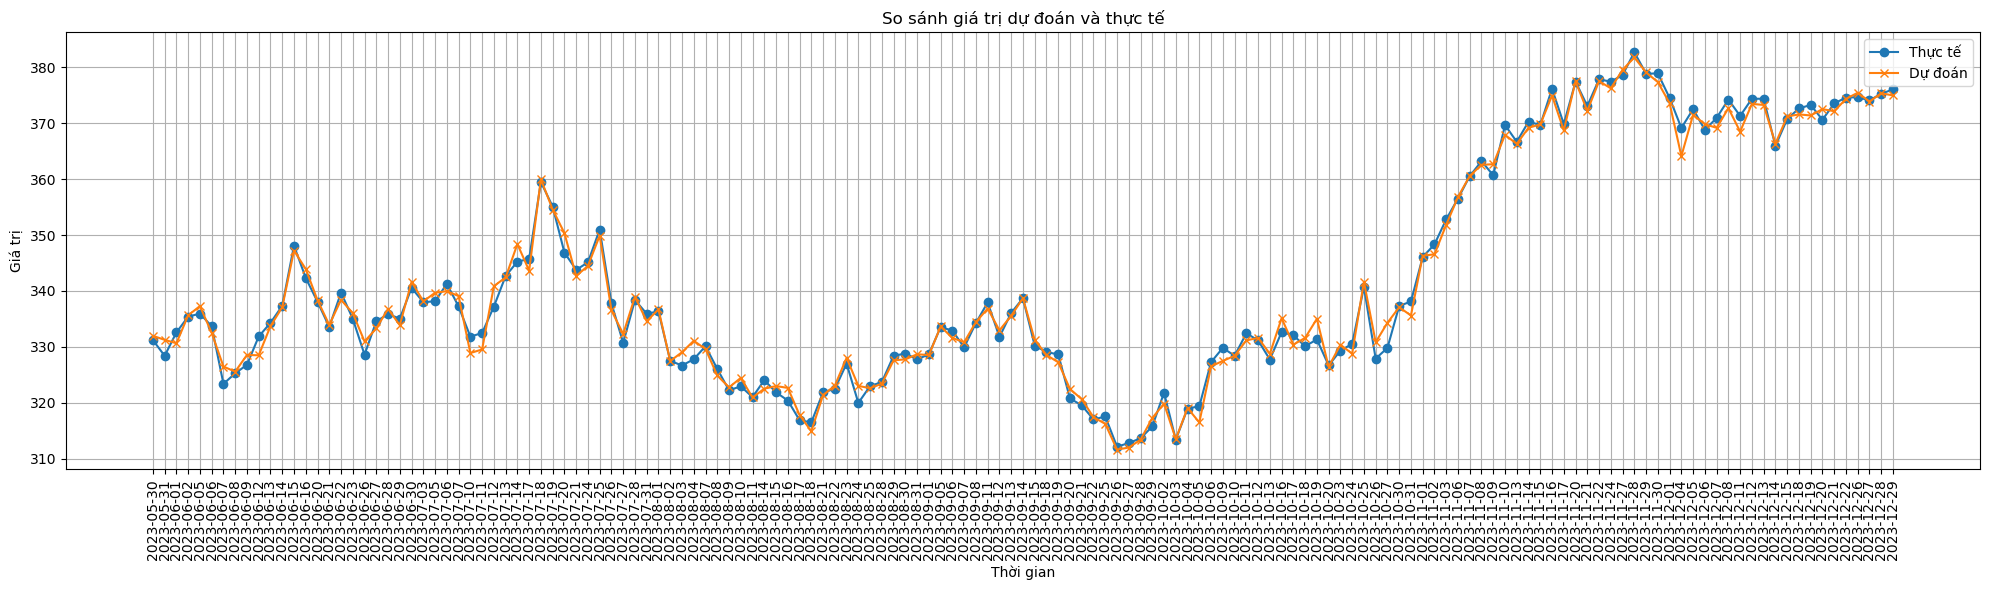

In [74]:
plt.figure(figsize=(20, 6))
plt.plot(time, y_target, label='Thực tế', marker='o')
plt.plot(time, y_val, label='Dự đoán', marker='x')
plt.xlabel('Thời gian')
plt.ylabel('Giá trị')
plt.title('So sánh giá trị dự đoán và thực tế')
plt.xticks(rotation=90)  # Xoay nhãn trục x để dễ đọc
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()